## SciPy


### Généralités

Vous l'aurez peut-être remarqué, si vous êtes un afficionado de MATLAB : certaines fonctions de votre programme préféré _manquent à l'appel !_ Par exemple, nous n'avons pas vu comment résoudre numériquement une équation différentielle, comment ajuster (_fitter_) des données autrement que par une droite, comment filtrer un signal, chercher les maxima d'une fonction ou ses zéros, ... voire même lire un fichier `.mat` de MATLAB ! C'est le but de ce module `Scipy`.

Scipy s'appuie beaucoup sur NumPy, donc je vous conseille d'avoir jeté un oeil au [tutoriel NumPy](./Application_A_Numpy.ipynb). Je recourrai assez souvent à des graphes afin d'y voir plus clair. Vous aurez donc également besoin de la base de la base de [Matplotlib](./Application_B_Matplotlib.ipynb) afin de ne pas être trop perdu.e. Je traiterai dans l'ordre :

- [le filtrage](#Filtrage) pour supprimer le bruit ou les composantes bizarroïdes de vos données expérimentales.
- [l'interpolation](#Interpolation) afin d'obtenir des données échantillonnées régulièrement. J'évoquerai également la possibilité d'utiliser l'interpolation pour atteindre une précision _sub-pixel_.
- [la recherche de maxima, minima et zéros](#Maxima,-Minima-et-Zeros) dans des séries de données, mais également pour des fonctions mathématiques à une ou plusieurs variables ...
- [la résolution d'équations différentielles](#Resolution-numerique-d'equations-differentielles) d'ordre 1 ou non, de systèmes d'équations différentielles et comment détecter des événements lors de leur résolution numérique.
- [des fonctions utilitaires en complément de Numpy](#Utilitaires) qui vont vous permettre :
    - de lire des fichiers `.mat` de MATLAB (si, si !)
    - d'effectuer des intégrations avec la méthode des trapèzes avec `scipy.integrate.cumtrapz()`
    - etc. etc.

------------------------------------------------------------------------

### Filtrage

Choisissons un signal $e(t)$ à temps _continu_. Filtrer ce signal revient à _convoluer_ celui-ci par une fonction de réponse $h(t)$: 

$$ s(t) = (h * e)(t) =  \int_{-\infty}^{\infty} e(\tau) h(t - \tau) {\rm d}\tau$$

Cette fonction $h$ peut être pensée pour dériver, intégrer, multiplier, etc. la fonction initiale $s(t)$. 

Dans cette section, en fonction de vos usages, nous allons voir comment filtrer des signaux : 

* En utilisant des filtres basés sur des _fonctions de transfert_, c'est à dire en travaillant dans l'espace de Fourier.
* En construisant explicitement des _fenêtres_ de filtrage $h(t)$. 
* En utilisant l'algorithme de _Savitsky-Golay_.

#### Fonctions de transfert
 
Dans cette section, nous allons apprendre à définir des fonctions de transfert 'à l'ancienne', c'est à dire dans l'espace de Fourier, puis de voir comment les 'convertir' en filtres numériques afin de les appliquer à des signaux échantillonnés régulièrement. Je vous montrerai enfin comment directement définir des filtres numériques qui se rapprochent de ces comportements.

##### Quelques rappels 

Les fonctions de transfert $H(j\omega)$ sont simplement les transformées de Fourier des fenêtres $h(t)$ que nous avons évoquées ci-dessus. Travailler dans l'espace de Fourier est très pratique car la convolution $*$ devient alors une simple multiplication $\times$, et les dérivations successives ou intégrations deviennent de simples facteurs $(j\omega)$ ou $(1/j\omega)$. On comprend alors tout l'intérêt d'effectuer : 

$$ s(t) = h(t) * e(t) \leadsto S(\omega) = H(j\omega) E(\omega)$$

Les années de licence ou de prépa nous ont également habitués à jouer avec des fonctions de transfert. On sait qu'elles ont pour forme habituelle quelque chose du genre : 

$$ H(j\omega) = \frac{b_0 (j\omega)^n + b_1 (j \omega)^{n-1} + ... + b_{n-1} (j \omega) +  b_n }{a_0 (j\omega)^n + a_1 (j \omega)^{n-1} + ... + a_{n-1} (j\omega) + a_n} $$

L'exemple général est un peu intimidant, mais si je décide unilatéralement que $b_n = a_n = 1$ et $a_{n-1} = 1/\omega_0$ et que tous les autres coefficients sont nuls, ma fonction de transfert devient : 

$$ H(\omega) = \frac{1}{1 + j \omega/\omega_0} $$ 

C'est à dire un bête filtre passe-bas d'ordre 1 de fréquence de coupure $\omega_0$ ! Chouette non ?

##### Afficher les fonctions de transfert : diagrammes de Bode

Scipy permet de _visualiser_ la réponse fréquentielle d'un filtre défini avec des $a_i$ et des $b_i$ via la fonction `scipy.signal.freqs()`. Cette fonction demande en entrée :
* les listes (ou tableaux) $b$ des coefficients $b_i$ de la puissance la plus élevée [$(j\omega)^n$] à la plus faible [$(j\omega)^0$].
* la même chose pour la liste $a$ des coefficients $a_i$.
* `worN` (lire $\omega$ or $N$) : le nombre (entier) de fréquences auxquelles vous voulez que votre filtre soit tracé, ou la liste explicite des fréquences qui vous intéressent.

La longueur maximale des tableaux $a$ et $b$, notée $n+1$, va définir l'_ordre_ du filtre que vous allez créer, qui sera donc _a priori_ $n$, à part, bien entendu, si vous mettez des zéros partout :-). Examinons le cas de notre filtre d'ordre 1 :

In [ ]:
import scipy.signal as spsi
import matplotlib.pyplot as plt
import numpy as np

omega_0 = 3
a = [1/omega_0,1]     
b = [0,1]

#            b_0 (jw) + b_1           1
#   H (w) = ----------------- = --------------
#            a_0 (jw) + a_1       jw/w_0 + 1

w, h_w = spsi.freqs(b,a, worN=np.logspace(-2,2,1000))
fig, ax = plt.subplots()
ax.semilogx(w, 20*np.log10(np.abs(h_w)))
ax.set_title('Bode diagram')
ax.set_ylabel('$G_{\\rm dB}$')
ax.set_xlabel('$\\omega$')
plt.show()

Je vous laisse vérifier qu'on a bien $-20 {\rm dB}$ par décade aux hautes fréquences, et que le $-3 {\rm dB}$ est bien atteint pour $\omega = \omega_0$.



__Exercices__ : 
* Créez un filtre passe-haut du deuxième ordre en précisant vous-même les coefficients $a$ et $b$ de votre filtre.
* Tracez la réponse _en phase_ du filtre de l'exercice précédent.

In [ ]:
# The ghost of undone homework is getting restless
#  .-.
# (o o)  "Doooo youuurrr exerrrciiissseeeesssss"
# | O \        
# \   \        
#  `~~~'

##### Quelques filtres analogiques

Vous vous douterez peut-être que les choses vont _un peu_ se corser si vous voulez appliquer des filtres d'ordre plus élevé, contrôler les facteurs de qualité ou faire de la réjection de bandes, etc. Ne vous inquiétez pas, _Scipy_ est là pour vous aider, et possède en fait des [filtres 'standards'](https://docs.scipy.org/doc/scipy/reference/signal.html#matlab-style-iir-filter-design) qui vont calculer les tableaux $a$ et $b$ pour vous. Par exemple, il est possible d'utiliser des filtres [Butterworth](https://fr.wikipedia.org/wiki/Filtre_de_Butterworth) avec la fonction `scipy.signal.butter()` qui prend en entrée : 

- L'ordre du filtre $n$
- La fréquence de coupure $\omega_0$ pour les filtres passe-bas ou haut ou les fréquences de coupure $(\omega_0, \omega_1)$ pour les filtres passe-bande ou coupe-bande. Celles-ci sont précisées en ${\rm rad}\cdot{\rm s}^{-1}$.
- `btype`, qui va préciser le type de filtre, par exemple `'lowpass'`, `'bandpass'`, `'bandstop'`, ...
- `analog`, que nous allons laisser à `True` pour l'instant.

Tentons de créer un filtre passe-bas d'ordre 2 de cette manière et examinons les coefficients $a$ et $b$

In [ ]:
import scipy.signal as spsi

b, a = spsi.butter(2, 0.5, analog=True, btype='lowpass')

print(b)
print(a)

La fonction de transfert que nous avons obtenue a donc la forme suivante : 

$$ |H(j\omega)| = \frac{1}{-4\omega^2 + 2 \sqrt{2} j\omega  + 1} \leadsto |H(j\omega)| = \frac{1}{\sqrt{1 + 16 \omega^4}}$$ 

C'est à dire la définition d'un filtre [Butterworth](https://fr.wikipedia.org/wiki/Filtre_de_Butterworth) d'ordre 2 avec $\omega_0 = 0.5~{\rm rad}\cdot{\rm s}^{-1}$. 

##### Appliquer des filtres analogiques

Dessiner des filtres, c'est bien joli, mais comment fait-on pour les _appliquer_ à un signal ? On peut pour cela utiliser _deux_ fonctions : 

* `scipy.signal.lfilter()` va filtrer le signal une fois
* `scipy.signal.filtfilt()` va appliquer _deux fois_ le filtre. Une première fois sur le signal initial à l'endroit, puis ensuite sur le signal filtré une fois mais _retourné temporellement_. 

Ces fonctions prennent bien en entrée : 
* les coefficients du numérateur $b$ 
* ceux du dénominateur, $a$
* et le signal $x$ 

Essayons de filtrer un signal correspondant à une sinusoïde de fréquence 1 Hz à laquelle nous avons ajouté du bruit :

In [ ]:
import numpy as np
import scipy.signal as spsi
import matplotlib.pyplot as plt

# Defining variables, then noise and filter
t = np.arange(0,6,0.005)                                 # Sampling frequency is 200 Hz
noise = 0.25*np.random.uniform(size=len(t))
e = np.sin(2*np.pi*t) + noise
b, a = spsi.butter(2, 4*np.pi, analog=True)             # Choosing f = 2 Hz for cutoff
s = spsi.lfilter(b, a, e)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.ylim([-2,2])
plt.show()

![img](./resources/kevin_horror.jpg)

__Que se passe-t-il ?!?__ : En fait, je vous ai un peu menti ... Les coefficients $a$ et $b$ à spécifier lors de l'appel aux fonctions `lfilter()` et `filtfilt()` ne sont pas ceux de l'espace de Fourier ... mais ceux de l'espace de la [transformée en Z](https://fr.wikipedia.org/wiki/Transformation_en_Z) ! En effet, notre signal n'est pas continu, mais _échantillonné_ à temps discret. Je choisis de volontairement ne pas en dire plus.

__Pour vous en sortir, vous devrez utiliser la fonction `scipy.signal.bilinear()`__. Celle-ci va prendre en entrée vos $a$ et $b$ analogiques et les transformer en $a_z$ et $b_z$ de la transformée en $Z$. Vous pouvez également lui passer l'argument `fs` correspondant à la fréquence d'échantillonnage de votre signal. Essayons de corriger le tir de la débâcle précédente :

In [ ]:
# Defining variables, then noise and filter
t = np.arange(0,6,0.005)                                 # Sampling frequency is 200 Hz
noise = 0.25*np.random.uniform(size=len(t))
e = np.sin(2*np.pi*t) + noise
b, a = spsi.butter(2, 10*np.pi, analog=True)              # Choosing f = 5 Hz for cutoff
bz, az = spsi.bilinear(b, a, fs=1/0.005)
s = spsi.lfilter(bz, az, e)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.ylim([-2,2])
plt.show()

Ah ! C'est bien mieux ! Le signal filtré et le signal original se ressemblent déjà bien plus. Cependant, le signal filtré est (légèrement) décalé en temps à cause du _déphasage_ lié au filtre. On peut corriger le tir en appliquant une deuxième fois le filtre, cette fois-ci sur le signal _retourné dans le temps_, puis en remettant _à l'endroit_ le résultat. C'est le concept de la fonction `filtfilt()` : 

In [ ]:
# Defining variables, then noise and filter
t = np.arange(0,6,0.005)                                 # Sampling frequency is 200 Hz
noise = 0.25*np.random.uniform(size=len(t))
e = np.sin(2*np.pi*t) + noise
b, a = spsi.butter(2, 10*np.pi, analog=True)              # Choosing f = 3 Hz for cutoff
bz, az = spsi.bilinear(b, a, fs=1/0.005)
s = spsi.filtfilt(bz, az, e)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.ylim([-2,2])
plt.show()

##### Il y avait plus rapide ... les filtres numériques !

On peut en fait _directement_ obtenir les coefficients $a$ et $b$ de vos filtres préférés dans l'espace de la transformée en $Z$ si on ... _enlève_ la condition `analog=True` lors de la construction de notre filtre ! Oups ... :-) . Dans un tel cas, 

* lors de la création de votre filtre, je vous conseille de préciser la fréquence d'échantillonnage $f_s$ de votre signal. Vous pourrez alors choisir des fréquences $f_0$ de coupure entre $0$ et $f_s/2$. Par défaut, $f_s=2$ et $f_c$ est alors comprise entre 0 et 1.
* si vous voulez examiner la réponse fréquentielle de votre filtre --cette fois-ci numérique--, vous devrez utiliser la fonction `scipy.signal.freqz()` avec un __z__ et pas un __s__.  

In [ ]:
# Defining variables, then noise and filter
t = np.arange(0,6,0.005)                                 # Sampling frequency is 200 Hz
noise = 0.25*np.random.uniform(size=len(t))
e = np.sin(2*np.pi*t) + noise
bz, az = spsi.butter(2, 3, fs=1/0.005)                  # Choosing f = 3 Hz for cutoff
s = spsi.filtfilt(bz,az,e)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.show()

__Exercice__ : Le signal suivant contient trois composantes en fréquence ($0.2$, $1$ et $3$ Hz). Essayez de définir un filtre numérique permettant de ne garder que la composante à 1 Hz. 

In [ ]:
t = np.arange(0,5,0.005)
e = np.sin(2*np.pi*t) - 2*np.sin(2*np.pi*0.2*t) + 0.3*np.cos(2*np.pi*3*t) 

# Plotting area : add your filtered plot here !
fig, ax = plt.subplots()
ax.plot(t,e)
plt.show()

#### Filtrage avec fenêtres

Si vous êtes plutôt du genre _espace direct_, vous pouvez également faire appel à des fonctions de fenêtrage explicites $h(t)$ parmi la [longue liste](https://docs.scipy.org/doc/scipy/reference/signal.windows.html) de fenêtres disponibles. Un choix assez classique consiste à choisir la fenêtre de [Hann](https://en.wikipedia.org/wiki/Hann_function), `scipy.signal.windows.hann()`, qui ne prend en entrée qu'un nombre $M$ de points, c'est à dire le nombre de points sur lequel on va effectuer le filtrage. Comme vous l'aurez constaté, ces fenêtres vont principalement _lisser_ le signal en effectuant un filtrage _passe-bas_ typiquement sur $M$ points, c'est à dire avec une fréquence de coupure de l'ordre de $f_s/M$.

Pour filtrer le signal avec ces fenêtres, on va ensuite simplement appeler la fonction `np.convolve()` ou `scipy.signal.convolve()` afin de calculer : 

$$ s(t) = (h * e) (t)$$

Par défaut, ces fenêtres ne sont pas normalisées, donc faites un tour par la case `sum()` pour la normaliser et voir votre filtre en action. Le tour est joué !

In [ ]:
import numpy as np
import scipy.signal as spsi

t = np.arange(0,6,1/100)            # Sampling frequency : 100 Hz
noise = 0.25*np.random.normal(size=len(t))
e = np.sin(2*np.pi*t) + 0.25*noise
window = spsi.windows.hann(20)      # Cutoff frequency : 100/20 = 5 Hz
window_norm = window/sum(window)
s = np.convolve(e, window_norm, mode='same')

# Plotting area
fig, ax = plt.subplots()
ax.plot(t,e, label='Signal Original')
ax.plot(t,s, 'r', label='Signal Filtré')
ax.legend()
plt.show()

__Exercice__ (difficile) : Essayez de développer une fenêtre permettant de dériver un signal (aux basses fréquences) tout en filtrant les hautes fréquences. Vous pouvez partir de la relation bien connue des [amateurs de distributions](https://fr.wikipedia.org/wiki/Distribution_(math%C3%A9matiques)) : 

$$ (e * h')(t) = \int e(\tau) h'(t - \tau) {\rm d}\tau = - \int e'(\tau) h(t - \tau)~{\rm d}\tau = (e' * h) (t) $$

In [ ]:
# *Eye of the Tiger starts playing in the background*

#### Le filtre de Savitsky-Golay

Dans la catégorie 'inclassables', le filtre de [Savistky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) est un filtre assez pratique qui va essayer de fitter par un polynôme d'ordre assez faible des bouts de taille $M$ de votre signal à filtrer. Ce filtrage par des polynômes est assez intéressant car il permet en outre de calculer la dérivée de votre signal initial tout en limitant le bruit habituellement associé au calcul des dérivées.

La fonction `spsi.savgol_filter()` prend donc naturellement comme arguments : 
* $e$, le signal à filtrer
* $M$, le nombre de points des bouts de signaux à fitter : c'est en fait la 'taille' du filtre. Ce nombre doit être impair.
* `polyorder`, l'ordre du polynôme utilisé pour ajuster les données
* `deriv` [optionnel] : précisez un entier $n$ pour obtenir la $n^{\rm ème}$ dérivée du signal filtré.

Le filtre renvoie alors directement les

In [ ]:
import numpy as np
import scipy.signal as spsi
import matplotlib.pyplot as plt

# Signal construction
t = np.linspace(-10,10,200)
noise = 0.15*np.random.normal(size=len(t))
e = noise + 2*t*np.exp(-t**2) + 0.1*t

# Signal filtering
s = spsi.savgol_filter(e, window_length=31, polyorder=3)

# Plotting area
fig, ax = plt.subplots()
ax.plot(t, e, label='Original')
ax.plot(t, s, 'r', label='Savitsky-Golay')
ax.legend()
ax.set_ylim([-1.5,1.5])
plt.show()

--------------------------------------------------------------------------

### Interpolation

L'interpolation de données s'effectue généralement lorsque les signaux qu'on mesure ne sont pas échantillonnés régulièrement. Certaines techniques, par exemple la [vélocimétrie laser Doppler](https://fr.wikipedia.org/wiki/V%C3%A9locim%C3%A9trie_laser), mesurent la vitesse locale dans un fluide ... mais seulement lorsqu'une particule traverse le faisceau laser ! Vous vous douterez bien que les traceurs ne vont pas gentiment s'organiser pour passer devant le détecteur à intervalles réguliers, et il est alors difficile, par exemple, de calculer le spectre de Fourier d'un tel signal.

Dans certains autres cas, il est parfois utile d'interpoler le signal pour avoir _plus de points_ de données que dans le jeu de données initial. Cela permet de combler certains trous et d'avoir un signal ou une image finaux d'aspect plus lisse, plus agréable à l'oeil.

Nous allons voir ici ce que le module `scipy.interpolate()` a dans le ventre !

#### Interpolation à une dimension 

L'interpolation à une dimension est une affaire assez simple et s'effectue avec la fonction `scipy.interpolate.interp1d()`. Vous aurez besoin pour cela de lui préciser : 
* les valeurs de $x$ sur lesquelles la fonction est calculée, qui n'est pas forcément trié.
* les valeurs de $y = f(x)$ de votre fonction aux $x$ précédemment mentionnés
* le _type_ (`kind`) d'interpolation, qui peut être au plus proche voisin (`'nearest'`), linéaire (`'linear'`), avec des splines cubiques (`'cubic'`), ...
* le comportement à avoir par rapport à l'extrapolation, avec `fill_value`: vous pouvez choisir un ou plusieurs nombres, ou préciser que vous voulez extrapoler les données avec `'extrapolate'`.

_La fonction `interp1d()` renvoie en retour un interpolateur_ : c'est l'estimation de la fonction $f$ obtenue par l'ordinateur. En pratique, c'est un objet à qui on va ensuite donner à manger la liste des points $x_i$ où l'on veut interpoler les données, et qui nous recrache les $f(x_i) = y_i$ qui nous intéressent. 

Essayons d'interpoler une fonction arbitraire à partir de données mal échantillonnées en $x$.

In [ ]:
import numpy as np
import scipy.interpolate as spint
import matplotlib.pyplot as plt

x = np.random.uniform(size=100) # Irregular x values
y = 5*x*np.exp(-5*x)

interpolator = spint.interp1d(x, y, kind='linear', fill_value='extrapolate')
xi = np.linspace(0,1,100)
yi = interpolator(xi)

fig, ax = plt.subplots()
ax.plot(xi, yi, 'r')
ax.plot(x, y, 'ko', markerfacecolor='k', markersize=2)
plt.show()

Ces interpolateurs peuvent être très puissants pour atteindre la [_précision sous-pixel_](https://dsp.stackexchange.com/questions/34103/subpixel-what-is-it) qui est parfois recherchée pour localiser des petits déplacements de particules ou des légers déphasages entre deux signaux. 

Prenons un signal $y_i$ qui possède un pic théorique étroit en $x_0=0.02$, mais qui n'est pas échantillonné en $x = x_0$. En l'interpolant par une [_spline_](https://fr.wikipedia.org/wiki/Spline), on va essayer de _retrouver_ la position du maximum théorique .

_Note_ : Cette méthode _ne fonctionne pas_ avec des interpolations linéaires ou de plus proche voisin.

In [ ]:
x = np.arange(-0.4,0.4,0.05)
noise = 0.01*np.random.uniform(size=len(x)) # Add a bit of noise to show the method is not perfect
y = np.sinc(3*(x-0.02))**2 + noise
x_0_naive = x[np.argmax(y)]

# Create the interpolator, then evaluate it close to x_0 with a smaller δx
interpolator = spint.interp1d(x, y, kind='cubic')
xi = np.linspace(x_0_naive-0.05,x_0_naive + 0.05,101)
yi = interpolator(xi)

# Check where we have found our maxima / compare with naive method
x_0_interp = xi[np.argmax(yi)]
print(f'Naive        estimate of maximum : {x_0_naive:.3f}')
print(f'Interpolated estimate of maximum : {x_0_interp:.3f}')

fig, ax = plt.subplots()
ax.plot(x , y , 'ko', markerfacecolor='k', markersize=2)
ax.plot(xi, yi, 'r')
plt.show()

Si vous répétez l'exécution de l'algorithme plusieurs fois, vous verrez que le maximum interpolé est bien détecté aux alentours de $x_0 = 0.02$ avec une variabilité de l'ordre de $\pm 0.003$, alors que le signal initial était faux de $-0.02$ ! 

Pour ceux que cela embêterait, sachez que je n'ai pas extrait de l'information du néant pour obtenir ma valeur du maximum. Les _splines_ qui interpolent le signal entre $x_i$ et $x_{i+1}$ ne se basent pas juste sur les valeurs $y_i$ et $y_{i+1}$. Elles exploitent également les informations du 'voisinage', c'est à dire $y_{i-1}, y_{i-2}, ..., y_{i+1}, y_{i+2}, ...$, qu'elles utilisent pour reconstruire plus fidèlement la fonction $f$.

Ce procédé de détection _sub-pixel_ de maxima est tout à fait applicable aux images à deux ou trois dimensions. Pratique pour déterminer le déplacement de petites particules sur de petites distances, ... par exemple dans un système de pinces optiques !

__Exercice__ (difficile !) : Essayez de déterminer le décalage (en millisecondes) entre les deux signaux d'électrocardiogrammes $y_1$ et $y_2$ du code ci-dessous. Calculez pour cela la corrélation croisée entre les signaux. _Note_ : Veillez à _normaliser_ vos variables avant d'essayer de les corréler :-)

In [ ]:
import json
import numpy as np
import scipy.interpolate as spint

# Loading the file
with open('./files/ecg_signal.json') as myfile:
    data = json.load(myfile)
t, y1, y2 = data['t'], data['y1'], data['y2']

# Wait ... so much code and it is not even resolved yet ? Jeeeeeezzzzz ....

#### Inerpolation à deux dimensions

L'interpolation à 2d ~~s'effectue assez facilement également avec la fonction `scipy.interpolate.interp2d()`~~ ... Perdu ! En fait, cette fois-ci, tout dépend de vos données initiales. Si celles-ci sont déjà _déjà placées sur une grille_ et que vous voulez les interpoler entre les points initiaux, vous pourrez utiliser `scipy.interpolate.RectBivariateSpline()`. Sinon, si vos données initiales sont éparpillées à des positions $(x,y)$ pas régulières, vous devrez utiliser `scipy.interpolate.griddata()`. 

##### Données structurées : `RectBivariateSpline()`

Essayons de dé-pixelliser une image d'un joli raton-laveur (ou tout du moins de son oeil). La fonction `scipy.interpolate.RectBivariateSpline()` est très bien adaptée aux images qui sont naturellement échantillonnées sur une grille bien régulière. La fonction est en plus assez similaire à `interp1d()` et va fabriquer à nouveau un interpolateur, qui aura cette fois-ci besoin d'une échelle en $x$ et en $y$. Vous ne serez pas dépaysé.e.s ! 

In [ ]:
import numpy as np
import scipy.interpolate as spint
import matplotlib.pyplot as plt
from scipy.misc import face     # Source of the image

# Generation and cropping of initial figure around a point of interest
x = np.arange(690,750)
y = np.arange(300,360)   
image = face(gray=True)[y[0]:y[-1]+1,x[0]:x[-1]+1] 

# Interpolation 
interpolator = spint.RectBivariateSpline(x,y,image)
x_refined = np.linspace(x[0],x[-1],500) # Refined --> more points than initially (60)
y_refined = np.linspace(y[0],y[-1],500) # Refined --> more points than initially (60)
image_refined = interpolator(x_refined, y_refined)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(image, cmap='gray')
ax[1].imshow(image_refined, cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Interpolated ')
fig.set_size_inches(w=13, h=7)

Notre image initiale est bien pixellisée, on voit d'ailleurs les gros pixels en question. L'image interpolée, elle, possède bien plus de pixels (cf. sur les axes), même si elle reste _floue_, car on ne peut à nouveau pas retrouver de l'information qui n'existait pas initialement :-) . L'interpolation a donc bien fonctionné.

##### Données échantillonnées aléatoirement : `griddata()`

Cette fois-ci, vous devrez simplement préciser les différents points $(x,y)$ où votre $f$ existe, et la fonction `griddata()` va se charger du reste ! Choisissons des coordonnées arbitrairement, puis calculons un $f(x,y)$ à ces endroits, avant d'effectuer l'interpolation.

La fonction `scipy.interpolate.griddata()` demande :
- des couples de coordonnées $(x,y)$ au format $N \times 2$
- la valeur de $z$ à ces coordonnées au format $N \times 1$
- les couples de nouvelles coordonnées $(x_i, y_i)$ auxquelles on souhaite calculer la fonction, au format $P \times 2$
- une méthode d'interpolation : `linear`, `cubic`, ...

Vous aurez donc à la fin également une liste de $P \times 1$ valeurs, que vous ne pourrez pas directement tracer comme surface. Pour quand même tracer une jolie surface, on va :
1. Créer nos grilles de coordonnées à deux dimensions $X_i$ et $Y_i$. 
2. On va ensuite aplatir ces grilles de coordonnées pour les transformer en listes 1d de coordonnées $x_i$ et $y_i$
3. Joindre ces données ensemble pour fabriquer $(x_i, y_i)$, que l'on va passer à `griddata()`
4. Re-transformer les données finales $f(x_i, y_i)$ en tableau 2d de même taille que la grille des $X_i$ et $Y_i$
5. Tracer les résultats, et s'apprécier pour le travail accompli 

![img](./resources/Self-love.jpg)

(image fournie par [Freepik](https://www.freepik.com/free-vector/high-self-esteem-illustration-with-woman-leaves_10781893.htm))

In [ ]:
import numpy as np
import scipy.interpolate as spint
import matplotlib.pyplot as plt

xy = 6*np.random.uniform(size=(300,2))-3            # Arbitrary (x,y) coordinates between -3 and 3
data = np.exp(-1/( (xy[:,0])**2 + (xy[:,1])**2))    # Well-shaped function :-)

interp_range = np.linspace(-3,3,100)
X_i, Y_i = np.meshgrid(interp_range, interp_range)      # Create 2d grid of X, Y coordinates
xy_i = np.transpose([np.ravel(X_i), np.ravel(Y_i)])     # Create P x 2 list of (x,y) coordinates
data_i = spint.griddata(xy, data, xy_i)                 # Interpolate the data
data_i_grid = np.reshape(data_i, X_i.shape)             # Put the interpolated data back on a grid

# 3d figure plotting
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(projection='3d')
ax.plot(xy[:,0], xy[:,1], data, 'k.', markersize=2)
ax.plot_surface(X_i, Y_i, data_i_grid, cmap='magma', alpha=0.5)
ax.set_title('Interpolation from initial points (black) using griddata()')
plt.show()

#### Interpolations à $d > 2$ 

Bonne nouvelle ! Vous pouvez utiliser `griddata()` pour interpoler des données à plus que deux dimensions. En fait, la fonction s'applique en dimensions arbitraires. Il faut juste remplacer votre couple de coordonnées $(x,y)$ de taille $N \times 2$ par une liste $(x,y,z,t,w,\ldots)$ de taille $N \times d$, et faire de même pour les coordonnées interpolées $(x_i,y_i,z_i,t_i,w_i,\ldots)$, mais sinon la syntaxe est exactement la même. 

Pour les données disposées initialement sur une grille, vous pouvez essayer d'utilier la fonction `scipy.interpolate.interpn()`, qui est un peu un amalgame entre `griddata()` et `RectBivariateSpline()` : 

- en premier, on lui précise un tuple qui contient les $x$ (taille $N_x \times 1$), $y$ (taille $N_y \times 1$), $z$ (taille $N_z \times 1$), ... 
- ensuite, les valeurs de la fonction en $(x,y,z,\ldots)$, donc un tableau de taille $N_x \times N_y \times N_z \times \ldots$
- enfin, la liste des points auxquels vous voulez calculer les données, qui est donc au format $P \times d$ si vous travaillez en dimension $d$. 

Je vous laisse un court exemple à ce sujet pour que vous évitiez de trop galérer avec la syntaxe. Si votre code déconne, vérifiez bien que la longueur des $(x,y,z,...)$ sont bien dans le même ordre que les dimensions de votre tableau de données initial (`values` dans l'exemple suivant). Si ça ne va pas, un petit coup de `indexing='ij'` dans `np.meshgrid()` ou une permutation de `(x,y,z)` en `(y,x,z)` dans l'appel à `interpn()` devrait faire l'affaire !

In [ ]:
import numpy as np
from scipy.interpolate import interpn

x = np.linspace(0, 4, 5)
y = np.linspace(0, 5, 6)
z = np.linspace(0, 6, 7)

X,Y,Z = np.meshgrid(x, y, z, indexing='ij')
values = X**2 + Y - 3*Z
eval_points = np.array([[3,3,2], [2,3,4], [4,5,6], [0,1,2]])
interpolated_vals = interpn((x,y,z), values, eval_points)

print('Initial data shape : ' + str(np.shape(values)))
print('Initial x,y,z, ... shapes : ' + str(len(x)) + ', ' + str(len(y)) + ', ' + str(len(z)))
print('Interpolated values : ' + str(interpolated_vals))

------------------------------------------------------------

### Maxima, Minima et Zeros

`Scipy` vous permet de trouver les maxima, les minima ou les zéros de séries de données à une ou plusieurs variables, c'est à dire de tableaux de données à $1,2,\ldots$ dimensions, mais également de fonctions -- dont on n'a _a priori_ pas encore calculé les valeurs. Cette section va donc être divisée en deux parties en fonction du type d'entrée dont vous souhaitez extraire les minimax ou zéros. Vous conviendrez d'emblée que rechercher des maxima d'une fonction $f(x,y,\ldots)$ revient à calculer les minima de $-f(x,y,\ldots)$, donc la recherche de minima et de maxima revient en fait _grosso modo_ au même. 

#### Minimax de séries de données 

Il existe deux fonctions pour détecter les pics locaux de séries de données, en fonction du nombre de dimensions du signal initial : 

* Pour une série 1d, on va utiliser la fonction `scipy.signal.find_peaks()`
* Pour des tableaux 2d et plus, on peut utiliser la fonction `scipy.ndimage.extrema()` pour récupérer le minimum et le maximum _global_ d'un tableau. Si vous voulez récupérer des pics locaux d'une série 2d, il existe également une fonction `peak_local_max()` dans le module [Scikit-Image](./Application_E_ScikitImage.ipynb).

##### Maxima d'un signal 1d avec `find_peaks()`

La fonction `scipy.signal.find_peaks()` va vous lister tous les pics d'un signal $s(t)$. Par défaut, c'est simplement tous les points pour lesquels la valeur de $s(t)$ est plus élevée que celle de ses deux voisins, triés de gauche à droite (et non du pic le plus grand au plus petit). Par exemple : 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as spsi

s = np.random.normal(size=100)
peaks,_ = spsi.find_peaks(s) # Don't forget the ", _" !

# Figure
fig, ax = plt.subplots()
ax.plot(s)
ax.plot(peaks, s[peaks], 'r^')
plt.show()

Cela fait _beaucoup_ de pics ... et vous voudrez peut-être ne conserver que les plus hauts, ou les plus élevés d'entre eux. Pour cela, vous pouvez vous appuyer sur certaines options : 

* `height`, qui va préciser l'ordonnée minimale à laquelle le pic doit se trouver
* `distance`, qui indique la distance minimale (en nombre de points) entre pics
* `prominence`, la [_proéminence_](https://fr.wikipedia.org/wiki/Pro%C3%A9minence) d'un pic, qui indique en gros de combien il faut que l'on 'redescende' d'un pic pour aller trouver un autre pic plus haut que celui-ci ou atteindre les bords du signal.  
* `threshold`, qui va indiquer de combien le pic doit être plus haut que les valeurs avoisinantes pour être comptabilisé. 

Pour `height`, `prominence` et `threshold`, vous pouvez préciser à la fois une limite _inférieure et supérieure_ en donnant à manger aux options une liste à deux éléments. 

__Exercice__ : Essayez donc de ne conserver que les six pics les plus hauts du signal suivant, puis les six pics les plus proéminents. Obtient-on les mêmes résultats ?  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as spsi

np.random.seed(1987)
s = np.random.normal(size=100)
peaks,_ = spsi.find_peaks(s) # Don't forget the ", _" !

# Figure
fig, ax = plt.subplots()
ax.plot(s)
ax.plot(peaks, s[peaks], 'r^')
plt.show()

##### Maximum d'un signal $d\geq 2$ avec `extrema()`

Cette fois-ci, la fonction est un peu plus rustique, et vous ne pourrez que lister le minimum et le maximum de votre tableau à $n$ dimensions. Si vous voulez obtenir les minimax _locaux_ à deux dimensions, jetez plutôt un oeil à la fonction `peak_local_max()` du module [Scikit-Image](./Application_E_ScikitImage.ipynb). La fonction vous renvoie un tuple `(min, max, loc_min, loc_max)`. Par exemple : 

In [ ]:
import scipy.ndimage as spnd

z = np.zeros((3,3,3))
z[2,2,0] = -2
z[0,2,1] = 3

min, max, loc_min, loc_max = spnd.extrema(z)
print(f'Minimum : {min} found at index {loc_min}')
print(f'Maximum : {max} found at index {loc_max}')

#### Minimisation et zéros de fonctions

Que se passe-t-il si, maintenant, au lieu de chercher un maximum dans votre série de données, vous auriez besoin de minimiser une _fonction_, c'est à dire trouver le minimum _exact_ (autant que possible avec Python) d'une fonction ? Ou de trouver les endroits où elle s'annule ? Les fonctions Scipy qui recherchent les extrema et les zéros s'utilisent avec une syntaxe similaire, mais sachez que pour le calcul des minimax, il vous faudra des fonctions _scalaires_, c'est à dire du type : 

$$f: \mathbb{R}^n \to \mathbb{R}$$

La fonction $f$ peut posséder de nombreuses variables, mais son résultat doit être un nombre. Pour le calcul des zéros, c'est un peu différent, car on a, même avec Scipy, besoin de $n$ équations pour déterminer $n$ variables :-). Les fonctions qui sont admissibles pour la recherche de zéros sont donc du type : 

$$h: \mathbb{R}^n \to \mathbb{R}^n$$

Les fonctions `scipy.optimize.minimize()` et `scipy.optimize.root()` (ainsi que leurs variants _scalaires_, `..._scalar()`) possèdent quasiment tous une syntaxe similaire en entrée, du type : 

* `fun` : la fonction à minimiser
* `x0` [parfois optionnel] : le $(x,y,\ldots)$ de départ pour l'algorithme
* `bounds` [optionnel] : les limites en $(x,y,\ldots)$ pour trouver le minimum 

Comment définir ma fonction $f$ en Python si on ne calcule pas ses valeurs ? Eh bien ... on va utiliser les fonctions Python. Eh, oui, on ne va pas réinventer la roue :-). On va donc créer nous-même $f$ avec une `def`, et on va _directement_ passer la fonction Python $f$ à la fonction `minimize_scalar()` qui va tenter de la minimiser.

Ces fonctions vont vous renvoyer un objet `result` (de type `OptimizeResult`, ce qui nous fait une bonne jambe), et qui contient quasiment toujours : 
* Un message, `result.message` (de type `str`)
* Un indicateur de la réussite de la recherche, `result.success` (un `bool`)
* La position (éventuelle) du minimum trouvé, $x$ avec `result.x`
* La valeur de $f$ au minimum $x$, `result.fun`

##### Minima à une dimension : `minimize_scalar()`

Choisissons une fonction biscornue $f(x) = \Gamma(x)/x^3$ avec [$\Gamma$ la fonction spéciale bien connue](https://fr.wikipedia.org/wiki/Fonction_gamma). Je sais que $\Gamma(x) \to \infty$ pour $x\to 0$ et $x \to \infty$ et que $f$ en fait de même, la fonction doit donc posséder un minimum. Je peux demander à `scipy.optimize.minimize_scalar()` de calculer le minimum de cette fonction pour moi. Cette fonction, contrairement à d'autres, n'a pas besoin d'un point de départ `x0`. Trouver son minimum va donc revenir à écrire :  

In [ ]:
import scipy.special as spec
import scipy.optimize as spop

def f(x):
    return spec.gamma(x)/x**3

result = spop.minimize_scalar(f, bounds=[0.1,10])
print('Minimum found at x = {:.3g}, f(x) = {:.3g}'.format(result.x, result.fun))

__Exercice__ : Essayez de déterminer le _maximum et le minimum_ de :

$$g(x) = \frac{x \ln(x)}{\exp(x)}$$

Puis tracez la fonction $g$ et affichez la position en $x$ et $y$ du maximum et du minimum de $g$ en surimpression sur le graphe. 

In [ ]:
# Piece of cake, mate. 

##### Minima a plusieurs dimensions : `minimize()`

La syntaxe est ici très similaire à ce que nous venons de voir, même si les objets sont plus compliqués à visualiser. Essayons avec la fonction :

$$ g(x,y) = (1-x)^2 + 100(x - y^2)^2 $$

Cette fonction est appelée fonction de [Rosenbrock](https://fr.wikipedia.org/wiki/Fonction_de_Rosenbrock), et possède un minimum très peu marqué en $(1,1)$.

La fonction `scipy.optimize.minimize()` fonctionne comme `minimize_scalar()`, hormis le fait que l'argument `x0` [qui est en fait $(x_0, y_0, \ldots)$] est nécessaire en entrée, et que l'objet renvoyé par `minimize()` contient plus d'informations, notamment sur les dérivées de $g$ au minimum trouvé.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop

g = spop.rosen      
    # Our g is simply the Rosenbrock function with no () because we
    # are not computing any values yet 
result = spop.minimize(g, x0=[0,0], bounds=[[-10,10],[-10,10]])
print(f'Minimum found at x, y = {result.x}, g(x,y) = {result.fun:.3f}')

# Graphical representation
fig, ax = plt.subplots()
extent = np.linspace(-3,3,300)
X, Y = np.meshgrid(extent, extent)
# Do not forget to set origin='lower' otherwise image will be flipped !
# Also specify the 'extent' option matching your $x$, $y$ range
ax.imshow(g((X,Y)), extent=[-3,3,-3,3], origin='lower', vmax=100) 
ax.plot(result.x[0], result.x[1], 'rs')
plt.show()

On retrouve donc bien notre maximum en $(1,1)$.

_Note_ : si vous n'êtes pas content.e.s de la position du minimum que vous avez trouvé, vous pouvez essayer de partir d'un autre point de départ $(x_0, y_0,\ldots)$. Si cela ne fonctionne pas _non plus_, vous pouvez essayer des algorithmes qui fonctionnent différemment, comme :
* [`scipy.optimize.basinhopping()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html#scipy.optimize.basinhopping), qui est capable de 'sauter' entre différentes 'vallées' pour ne pas rester bloqué dans un minimum local qui n'est pas global
* [`scipy.optimize.dual_annealing()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html#scipy.optimize.dual_annealing), qui va simuler une le mouvement d'une particule 'brownienne' fictive qui va tomber dans le puits de potentiel correspondant à votre fonction lors d'un recuit simulé. 
* [`scipy.optimize.brute()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html#scipy.optimize.brute), qui va chercher par force brute le minimum de votre fonction en calculant ses valeurs partout, à intervalles réguliers.

##### Zéros d'une fonction à une dimension `root_scalar()`

Cherchons le ou les zéros de la fonction :

$$ h(x) = 1 + x - 2\cos x $$

Si on réfléchit au signe de la dérivée de $h$, on a plusieurs zéros, et la fonction `scipy.optimize.root_scalar()` va trouver _un seul_ d'entre eux. Intuitivement, on se dit que celui qui sera trouvé est le plus proche du point de départ, non ? Essayez de changer le `x0` dans le code suivant, exemple en choisissant $x_0 = 0$, puis $-0.75$, $-0.80$, $-0.95$, $-1$ et examinez le résultat : 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop

def h(x): return 1 + x - 2*np.cos(x)

# Root finding
x0 = -0
result = spop.root(h, x0=x0)

# Figure
x_list = np.linspace(-5,5,500)
fig, ax = plt.subplots()
ax.plot(x_list, h(x_list))
ax.plot(x_list, 0*x_list, 'k:')
ax.plot(x0, h(x0), 'g>', label='Initial point')
ax.plot(result.x, result.fun, 'rs', label='Zero of $h$')
plt.legend()
plt.show()

Le maximum trouvé n'est pas forcément celui le plus proche du point de départ, donc faites attention et veillez à tester un peu en détail la _robustesse_ de votre résultat ! 

##### Zéros d'une fonction plusieurs dimensions : `root()` 

Considérons une fonction $h$ à plusieurs variables, $(x,y)$ et qui renvoie elle-même deux valeurs : 

$$ h (x,y) = \left (\begin{array}{c} \exp(x) - y \\ y^2 - 5 \end{array}\right ) $$

Si on se creuse un peu la tête, on peut voir que la solution de $h(x,y) = (0,0)$ revient en fait à écrire $y = \exp(x) = \sqrt{5}$. Comment s'en sort notre algorithme ? Ma foi, plutôt bien : 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop

def h(xy):
    x,y = xy[0], xy[1]
    return [np.exp(x) - y, y**2 - 5]

result = spop.root(h, x0=[0.5,0.5])

print(f'Zero found at x, y = {result.x}')

Une fois de plus, si vous savez que votre fonction _a de nombreux zéros_, faites attention à votre point de départ !

--------------------------------------------------

### Ajustements et _fits_



L'ajustement et le _fit_ de données est, en fait, une simple optimisation (minimisation) de fonction, mais comme je vous connais un peu, je me doute que vous n'allez pas vraiment regarder dans la section ci-dessus pour aller fitter des données :-). Donc je mets la section à ce sujet ici. 

Le concept du _fit_ n'est pas super difficile à comprendre : vous avez des données $x_i$, $y_i$ et vous tentez de faire passer une courbe du type $f(x)$ à travers les $x_i$. Dans le cas le plus idéal, vous avez exactement $f(x_i) = y_i$, mais en pratique vous aurez toujours du bruit dans les données, des petites erreurs systématiques. Dans le cas d'un bon fit, $f(x_i) - y_i$ ne va jamais être nul, mais petit. L'objectif des fonctions de fit est de trouver une fonction $f$ qui minimise la distance $D$ entre $f(x_i)$ et les $y_i$ : 

$$ D = \sum_i \left | f(x_i) - y_i \right |^2 $$

Bien entendu, on ne peut pas laisser Scipy choisir n'importe quelle fonction $f$ : on doit lui fournir une idée de la fonction $f$ à ajuster (_fitter_). On va en fait lui donner des familles de fonctions $f_{a,b,c,\ldots}(x)$ qui possèdent des _paramètres_ $a,b,c,\ldots$. Scipy peut alors tenter de minimiser $D(a,b,c,\ldots)$, qui est maintenant une simple fonction à plusieurs variables !

Dans cette section, on va d'abord regarder comment définir notre distance $D$ à la main pour ensuite _fitter_ une courbe à des données avec `scipy.optimize.least_squares()`, puis ensuite nous verrons qu'on peut plus directement _fitter_ $f$ à des données sans définir $D$ via `scipy.optimize.curve_fit()`. Si vous voulez faire des simples ajustements linéaires, vous pouvez jeter un oeil à [`scipy.optimize.lsq_linear()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.lsq_linear.html#scipy.optimize.lsq_linear), voire à la méthode [`np.linalg.lstsq()`](./Application_A_Numpy.ipynb/#Regression-lineaire) vue dans l'Application A.

En pratique : sachez qu'au delà de deux paramètres, les _fits_ vont quasiment toujours fonctionner, et que leur convergence va être de plus en plus délicate. Les algorithmes de _fit_ ont également des difficultés lorsque deux paramètres ont quasiment le même effet sur la fonction $f$. 

_Note_ : Dans la vie réelle, vous n'aurez pas toujours d'expression explicite $y=f(x)$, mais plutôt $x = g(y)$ ... et rien ne vous empêche de fitter $g$ ! Si, par contre, vous avez une expression du type $h(x,y, \ldots)=0$, alors, euh, là ça risque d'être un peu plus compliqué...

#### implicit fit with h(x,y)=0 ?

#### Minimisation d'une distance $D$ explicite : `minimize()` et `least_squares()`

Partons d'une série de données $y_i$. Comme je construis ici une série de données de toutes pièces, je vais écrire : 

$$ y_i = f_* (x_i) + \zeta_i$$

C'est à dire que $y_i$ est la somme d'une _fonction à retrouver_ $f_*$ et d'un bruit $\zeta$. A priori, je ne suis pas censé connaître $f_*$, mais j'ai une vague idée de ce à quoi elle ressemble, quelque chose du type :

$$ f_{a,b}(x) = \exp(-a x) \sin(b x) $$ 

On veut retrouver les valeurs de $a$ et $b$. Dans notre code Python, on va donc définir une 'fonction' (au sens Python) définissant la famille des fonctions (mathématiques) $f_{a,b}$. On va donc devoir donner à manger à la fonction Python `f` en entrée : 
* les valeurs `x` auxquelles la fonction sera évaluée plus tard
* les paramètres `prms` $a$ et $b$, que je mets dans une liste. Ils vont venir modifier la forme des $f$

Je peux utiliser les $f$ avec un jeu de `prms` bien précis pour créer les $y_i$. Je peux ensuite définir une nouvelle fonction Python `D` qui prend en entrée `prms` et renvoie la somme des carrés des `y_i - f(x_i,prms)`. On peut alors simplement minimiser $D$ en utilisant [`scipy.optimize.minimize()` vue précédemment](#minima-a-plusieurs-dimensions--minimize). Celle-ci demande en entrée la fonction à minimiser, `D`, et un point de départ pour vos paramètres, `x0` : 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop

def f(x, prms):
    return np.exp(prms[0]*x)*np.sin(prms[1]*x)

def D(prms):
    return np.sum((y_i - f(x_i, prms))**2)

# Data generation
x_i = np.linspace(0,6,30)
y_i = f(x_i, [-0.5,np.pi]) + 0.2*np.random.normal(scale=0.2,size=len(x_i))

# Fit using the explicit (summed, squared) distance function D and minimize
result = spop.minimize(D, x0=[-1,1])
print(f'Result of minimize : f(x) = exp({result.x[0]:.2f} x) sin({result.x[1]:.2f} x)')

# Plot
fig, ax = plt.subplots()
x = np.linspace(0,6,200)
plt.plot(x_i, y_i, 'ks')
plt.plot(x, f(x, result.x))
plt.show()

Et voilà, on a fitté une fonction _à la main_ ! On peut aller _un peu plus rapidement_ sous Scipy en ne définissant pas explicitement $D$ (la somme des carrés des distances) mais simplement les distances individuelles $d_i$ : 

$$ d_i = y_i - f(x_i)$$

et en appelant `scipy.optimize.least_squares()`. Cette fonction renvoie _grosso modo_ le même objet que `minimize()` : 

In [ ]:
# Data generation
x_i = np.linspace(0,6,30)
y_i = np.exp(-0.5*x_i)*np.sin(np.pi*x_i) + 0.2*np.random.normal(scale=0.2,size=len(x_i))

def f(x, prms):
    return np.exp(prms[0]*x)*np.sin(prms[1]*x)
def d_i(prms):
    return y_i - f(x_i,prms)

# Fit using (non-summed, non-squared) and least_squares()
result = spop.least_squares(d_i, x0=[-0.5,3])
print(f'Result of least_squares : f(x) = exp({result.x[0]:.2f} x) sin({result.x[1]:.2f} x)')

# Plot
fig, ax = plt.subplots()
x = np.linspace(0,6,200)
plt.plot(x_i, y_i, 'ks')
plt.plot(x, f(x, result.x))
plt.show()

#### Ajustements faciles avec `curve_fit()`

Bon, maintenant que vous avez compris le concept de l'ajustement de courbes, sachez qu'il existe une fonction plus pratique sous Scipy pour fitter vos données. Elle s'appelle `scipy.optimize.curve_fit()`. Cette fois-ci, on ne définit plus ni $D$ ni $d_i$, juste $f$, et on passe à la fonction :

* la fonction `f` à fitter : elle doit être écrite comme `f(x,a,b,c,...)` avec les `x` _en premier argument_, puis ensuite les _paramètres `prms` __non__ regroupés dans une liste_. 
* les `x_i` obtenus dans l'expérience
* les `y_i` obtenus dans l'expérience
* un point de départ `p0` pour les différents paramètres 

Cette fois-ci, la fonction ne renvoie qu'un `tuple` contenant : 
* les meilleurs paramètres de _fit_ (a,b)
* la [matrice de covariance](https://fr.wikipedia.org/wiki/Covariance). Cette matrice est de taille $N \times N$ pour un fit à $N$ paramètres, et ses éléments diagonaux (plus exactement leur racine) nous renseigne sur les _incertitudes_ sur les paramètres de fit.

Result of curve_fit : f(x) = exp(-0.52 x) sin(3.17 x)


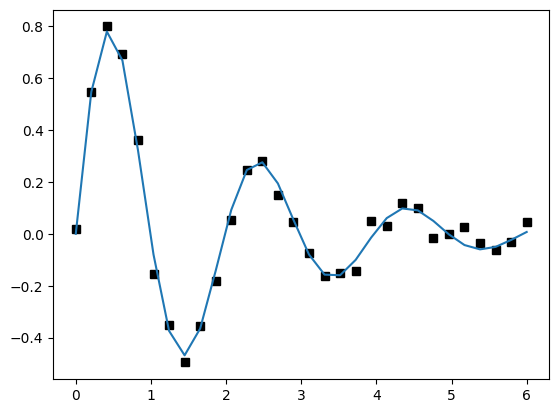

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as spop

# Data generation
x_i = np.linspace(0,6,30)
y_i = np.exp(-0.5*x_i)*np.sin(np.pi*x_i) + 0.2*np.random.normal(scale=0.2,size=len(x_i))

# Fit using curve_fit
def f(x, a, b):
    return np.exp(a*x)*np.sin(b*x)
ab, covariance = spop.curve_fit(f, x_i, y_i, p0=[-0.5,3])
print(f'Result of curve_fit : f(x) = exp({ab[0]:.2f} x) sin({ab[1]:.2f} x)')

# Plot
fig, ax = plt.subplots()
plt.plot(x_i, y_i, 'ks')
plt.plot(x_i, f(x_i, ab[0], ab[1]))
plt.show()

Enfin, sachez que : 

* si vous avez beaucoup plus de points de données que de paramètres de fit, en gros si vous avez plus de 30 points de données
* que les erreurs sur les données suivent une loi _normale_, c'est à dire qu'il n'y a pas d'erreur systématique, et que l'erreur ne dépend pas par exemple de $x$, on parle d'[_homoscédasticité_](https://en.wikipedia.org/wiki/Homoscedasticity_and_heteroscedasticity) (si, si !).
* que les paramètres ne sont pas trop corrélés entre eux (c'est à dire que les éléments hors-diagonale de la matrice de covariance sont faibles devant les éléments diagonaux)

On peut obtenir un intervalle de confiance $I$ à partir de la valeur du paramètre estimée $p_i$ et la valeur de la matrice de covariance sur la diagonale $C_{ii}$ :
* à 90 % : $I_i = [p_i - 1.65\sqrt{C_{ii}} ; p_i + 1.65\sqrt{C_{ii}}]$
* à 95 % : $I_i = [p_i - 1.95\sqrt{C_{ii}} ; p_i + 1.95\sqrt{C_{ii}}]$
* à 99 % : $I_i = [p_i - 2.58\sqrt{C_{ii}} ; p_i + 2.58\sqrt{C_{ii}}]$

In [16]:
a, b = ab[0], ab[1]
covstd_a = np.sqrt(covariance[0,0])
covstd_b = np.sqrt(covariance[-1,1])

print(f'95% confidence "Gaussian" uncertainty on a : [{a - 1.95*covstd_a:.3f};{a + 1.95*covstd_a:.3f}]') 
print(f'95% confidence "Gaussian" uncertainty on b : [{b - 1.95*covstd_b:.3f};{b + 1.95*covstd_b:.3f}]') 

95% confidence "Gaussian" uncertainty on a : [-0.552;-0.485]
95% confidence "Gaussian" uncertainty on b : [3.136;3.202]


Si vous êtes malchanceux et que votre nombre de données est plus faible, ne vous inquiétez pas. La formule est _un peu_ plus compliquée et implique de calculer le nombre de degrés de liberté de votre fit, c'est à dire le nombre de points de données moins le nombre de paramètres. On doit également passer par la [distribution $t$ de Student](https://fr.wikipedia.org/wiki/Loi_de_Student) plutôt qu'une simple loi normale ... Donc, pour notre problème et un intervalle de confiance à  $\alpha$ pour cent, par exemple 95, nous obtenons : 

In [17]:
from scipy.stats.distributions import t

alpha = 95
deg_of_freedom = len(x_i) - len(ab)

alpha_normed = 1 - (1-alpha/100)/2
tval = t.ppf(alpha_normed, deg_of_freedom)

print(f'{alpha}% confidence "t-Student" uncertainty on a : [{a - tval*covstd_a:.3f};{a + tval*covstd_a:.3f}]') 
print(f'{alpha}% confidence "t-Student" uncertainty on b : [{b - tval*covstd_b:.3f};{b + tval*covstd_b:.3f}]') 

95% confidence "t-Student" uncertainty on a : [-0.554;-0.484]
95% confidence "t-Student" uncertainty on b : [3.134;3.204]


__Exercice__ : 

* Tracez la densité de probabilité des `random_vars` (ci-dessous) tirées aléatoirement ci-dessous en fonction du nombre d'échantillons $N$ (`nsamples`). Tentez ensuite de _fitter_ cette densité par une gaussienne, et tentez enfin de déterminer la précision que vous êtes capables d'obtenir sur les paramètres de fit en fonction du nombre d'échantillons $N$. Comment l'incertitude décroît-elle avec $N$ ?
* (Difficile !) Seriez-vous capables de _fitter_ la distribution des `random_vars` _sans passer par des histogrammes_ (c'est à dire ni `np.histogram`, ni `plt.hist`, ...) ? Quelle précision obtenez-vous sur les paramètres de fit dans un tel cas ? _Indice_ : vous pouvez commencer par _trier_ les valeurs des tirages aléatoires que vous avez obtenues :-)

In [ ]:
import numpy as np
import scipy.optimize as spop

avg, sigma, nsamples = 1.7,2.3,  [100,1000,10000,100000,1000000]
random_vars = [np.random.normal(loc=avg, scale=sigma, size=nsample) for nsample in nsamples]


----------------------------------

### Resolution numerique d'equations differentielles 

Comme nous l'avons déjà fait dans la section [Minimisation/Maximisation](#minima-a-plusieurs-dimensions--minimize), pour résoudre numériquement notre équation différentielle, nous allons d'abord créer des 'fonctions' (Python) qui vont reformuler des équations différentielles, que nous allons systématiquement écrire sous la forme. 

$$y' = f(t,y)$$

Ensuite, on donnera à manger  à la 'fonction' Python `scipy.integrate.solve_ivp()` (pour _initial value problem_, problème aux conditions initiales) :

- La fonction $f(t, y)$ __définie sous Python avec $t$ en premier et $y$ ensuite__.
- La plage de $t = [t_0, t_f]$ nommée `t_span` sur laquelle vous voulez résoudre l'équation différentielle.
- La condition initiale $y_0$, c'est à dire la valeur de $y$ pour $t =t_0$. __Celle-ci doit être un tableau ou une liste, même si celui/celle-ci ne contient qu'une valeur__, par exemple `y0 = [0]`, mais pas `y0 = 0`. 

Vous pouvez préciser des arguments optionnels, comme :

- `t_eval` afin de préciser les points où vous voulez explicitement calculer la solution de votre équation différentielle. 
- `method`, l'algorithme de résolution de votre équation différentielle. Il en [existe beaucoup](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp), et certains d'entre eux s'en sortent mieux et sont plus rapides pour résoudre des problèmes difficiles sur lesquels le solveur par défaut (`RK45`) va buter.

La fonction `solve_ivp()` renvoie un objet `result` de type _Bunch_, qui contient notamment les attributs suivants : 

- `t`, les endroits où sont évaluées les fonctions $y(t)$ et $y'(t)$
- `y`, qui est une liste à deux éléments. `y[0]` correspond à $y(t)$ et `y[1]` correspond à $y'(t)$
- `success`, qui indique si la procédure d'intégration a bien fonctionné
- `message`, qui vous en dit plus sur comment s'est terminée l'intégration

#### Résolution d'une simple équation différentielle du premier ordre

Prenons une équation différentielle ordinaire du premier degré, mais pas forcément linéaire, du type : 

$$ y' =  -\frac{y^2}{(1 + t^2)} = f(t,y) $$

Les petits malins auront déjà noté que $y(t) =1/[c^{te} + {\rm Arctan(t)}] $ :-). Choisissons de la résoudre sur $[0;10]$ avec $y(0) = 1$ (c'est à dire $c^{te} = 1$). La syntaxe est plutôt simple : 

In [ ]:
import numpy as np
import scipy.integrate as sping
import matplotlib.pyplot as plt

# Resolution of the ode :
def yprime(t,y):
    return -y**2/(1+t**2)
f = sping.solve_ivp(yprime, t_span=[0,10], y0=[1], t_eval=np.linspace(0,10,500))

plt.plot(f.t, f.y[0], label='Numerical integration')
plt.plot(f.t, 1/(1+np.arctan(f.t)), 'r:', label='Original function') # for comparison, the actual function

plt.legend()
plt.show()

__Exercice__ : Essayez de jouer dans le code ci-dessus avec `t_span`, `t_eval` et `y0` pour tracer la fonction $y_* = 1/{\rm Arctan} (t)$ (soit $c^{te} = 0$)



#### Equations d'ordre deux, systemes d'equations :

La stratégie habituelle pour résoudre les équations d'ordre deux ou plus consiste à _vectoriser_ l'équation différentielle initiale. Hein ? Prenons un exemple d'équation méchante du deuxième degré : 

$$ y'' = \mu(1-y^2) y' - y = f(t,y,y')$$ 

C'est en fait un [Oscillateur de van der Pol](https://fr.wikipedia.org/wiki/Oscillateur_de_Van_der_Pol). Il est possible de voir cette équation du deuxième degré comme une équation du premier degré pour un _vecteur_ ${\bf Y} = (y, y')$ : 

$$ {\bf Y'} = \left ( \begin{array}{c} y' \\ y'' \end{array} \right ) = \left ( \begin{array}{c}  y' \\ \mu(1-y^2)y' - y \end{array} \right ) = \left ( \begin{array}{c}  y' \\ f(t,y,y') \end{array} \right ) = \mathcal{F}({\bf Y})$$

Vous voyez donc qu'il est en pratique assez facile de généraliser ce résultat à l'ordre $n$. Il va alors falloir préciser les conditions initiales pour ${\bf Y}$, c'est à dire de $y, y', y'', \ldots, y^{(n-1)}$ pout $t=t_0$, ... mais c'est en fait le cas même quand on intègre à la main :-). Sous Python, je décide de choisir `Y` tel que :

* `Y[0]=y`
* `Y[1]=yprime` 

On aura donc, dans la définition de `Yprime()` :

* `Yprime[0] = Y[1] = yprime` 
* `Yprime[1] = f(y)` 

On va laisser ensuite `solve_ivp()` faire le sale boulot. On peut vérifier que le solveur fait bien son travail en choisissant $\mu=0$, $y(t=0)=0$ et $y'(t=0)=1$. On a alors assez simplement $y = \sin(t)$. Vous pouvez ensuite jouer avec la valeur de $\mu$ et observez comment $y(t)$ s'écarte de la fonction sinus de base. 

In [ ]:
import numpy as np
import scipy.integrate as sping
import matplotlib.pyplot as plt

def Yprime_vdp(t,Y,mu=5):  
    return [Y[1],mu*(1-Y[0]**2)*Y[1]-Y[0]]

t_eval = np.linspace(0,25,2000)
f = sping.solve_ivp(Yprime_vdp, t_span=[np.min(t_eval),np.max(t_eval)], y0=[0,1], t_eval=t_eval, method='RK45')

fig, ax = plt.subplots()
ax.plot(f.t, f.y[0], label='Numerical integration')
ax.plot(t_eval, np.sin(t_eval), 'r:', label='Analytical solution')

plt.legend()
plt.show()

__Exercice__ : Modifiez la valeur de $\mu$ pour lui donner une valeur vraiment élevée ($\geq 1000$) et demandez à `solve_ivp()` de vous calculer une solution sur $[0,500]$. Tentez de changer de _solveur_, pour par exemple choisir le solveur RADAU5 (`'Radau'`) ; comparez les résultats du solveur initial et du solveur RADAU5. Notez-vous une différence entre les deux solutions ?

Il est tout à fait possible de simuler des _systèmes_ d'équations différentielles de la même manière. Si nous partons d'un système d'équations de [Lotka-Volterra](https://fr.wikipedia.org/wiki/%C3%89quations_de_pr%C3%A9dation_de_Lotka-Volterra) : 

$$ \left \{ \begin{array}{rl}  x' = x(a - b y)\\ y' = y(dx - c) \end{array} \right .$$

On peut très bien résoudre le problème en définissant une variable `XY` telle que : 
* `XY[0]` vaut $x$
* `XY[1]` vaut $y$

On définit comme précédemment un `XYprime` tel que : 
* `XYprime[0]` vaut $x(a -by)$
* `XYprime[1]` vaut $y(dx - c)$

Et on laisse une fois de plus `solve_ivp()` se charger du reste. 

__Exercice__ : Résolvez le système d'équations différentielles mentionné ci-dessus pour $a = 2/3, b = 4/3, c = 1$ et $d=1$, et tracez les valeurs de $x$ (population de proies) et celle de $y$ (population de prédateurs). Essayez de modifier les conditions initiales et observez le changement obtenu sur le résultat. 

#### Événements

Parfois, des événements peuvent également survenir dans votre équation différentielle. Par exemple, un modèle de rebond d'une bille (ou d'une boule de canon) : la bille est affectée par la gravité, ce qui donne $y'' = -g$, mais le sol en $y=0$ termine l'expérience. 

* Peut-on détecter ces _événements_ lors de la résolution de l'équation différentielle ? La réponse est _oui_, même si la syntaxe pour effectuer une telle opération est _vraiment bizarre_. Je vais vous l'expliquer dans cette section, largement reprise de la [documentation Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).
* Peut-on utiliser ces _événements_ pour modifier le comportement de l'équation différentielle (par exemple pour modéliser un _rebond_) ? Cette fois-ci, la réponse est malheureusement _non_. Il vous faudra résoudre les équations de $t =0$ à $T$, trouver le temps où le premier événement se produit $t_{\rm ev} < T$ et redémarrer une résolution d'équations pour le système pour $t\geq t_{\rm ev}$ ... et ce pour chaque événement... gloups ! 

Revenons à notre cas de balle pas rebondissante. Écrivons notre équation différentielle en créant un ${\bf Y} = \left( \begin{array}{c} y \\ y' \end{array} \right )$. 

In [ ]:
import numpy as np
import scipy.integrate as sping
import matplotlib.pyplot as plt
%matplotlib widget

def Yprime_ball(t, Y, g=9.81):
    return [Y[1],-g]

t_eval = np.linspace(0,3,1000)
f_naive = sping.solve_ivp(Yprime_ball, y0=[0,9.81], t_span=[np.min(t_eval), np.max(t_eval)], t_eval=t_eval)

fig, ax = plt.subplots()
ax.plot(f_naive.t, f_naive.y[0])
ax.plot(f_naive.t, 0*f_naive.t, 'k:')  # Reference line
plt.show()

Oups ! Notre balle est passée à travers le sol, ce n'est pas très réaliste... Tentons donc de définir une fonction `hit_ground` : pour que l'événement se produise, il faut que ce qui est renvoyé par `hit_ground` vaille zéro. Dans notre cas, la condition de notre événement est simplement $y=0$. Notre fonction `hit_ground` doit donc très simplement renvoyer `Y[0]`. On va ensuite préciser : 

- Dans quel sens ce qui est évalué dans l'événement doit passer par zéro (par exemple de positif à négatif --> -1, ou de négatif à positif --> + 1) pour que l'événement soit compté. C'est l'attribut `direction`
- Si l'événement vient terminer l'intégration. Par exemple, une bulle peut être complètement dissoute lorsqu'elle atteint $R=0$, cela n'a alors pas trop d'intérêt d'examiner le comportement de l'équation pout $t > t_{\rm dissolution}$. C'est l'attribut `terminal`. Dans notre cas, il est vrai (`True`)

Bizarrement, on va _ajouter_ ces attributs à la fonction 'à la main' après avoir défini la fonction. On va ensuite rappeler `solve_ivp` et lui ajouter un argument `events`, auquel on va passer la fonction `hit_ground`. Examinez plutôt : 

In [ ]:
def hit_ground(t,Y):
    return Y[0]
hit_ground.direction = -1
hit_ground.terminal = True

f_hit_ground = sping.solve_ivp(Yprime_ball, y0=[0,9.81], t_span=[np.min(t_eval), np.max(t_eval)], 
                                    t_eval=t_eval, events=hit_ground)

fig, ax = plt.subplots()
ax.plot(f_naive.t, f_naive.y[0])
ax.plot(f_hit_ground.t, f_hit_ground.y[0], 'r')
ax.plot(f_naive.t, 0*f_naive.t, 'k:')  # Reference line
plt.show()

Vous noterez enfin que l'objet contenant les résultats `f_hit_ground` vous indique désormais à quel(s) instant(s) et quelles valeurs de ${\bf Y}$ les événements se sont produits, avec les attributs `.t_events` et `.y_events`. Assez logiquement, notre balle a effectué un vol d'exactement $2$ secondes.

__Exercice__ (difficile) : Supposons un chat initialement au repos qui chute progressivement à partir de $t=0$. Il subit alors une force de traînée en $F_d = k v^2\simeq 0.03 v^2$ et la force de gravité $F_g = -mg$ avec $m = 4$ kg. Déterminez à l'aide d'un événement de `solve_ivp()` l'instant et la distance de chute à partir desquels le chat atteint $95\%$ de sa vitesse maximale.

In [ ]:
import numpy as np
import scipy.integrate as sping
import matplotlib.pyplot as plt

m, g = 4, 10
k = 0.03

def freefall(t, Y, m=m, g=g, k=k):
    return [Y[1],-m*g -k*Y[1]*np.abs(Y[1])] # Drag must be <0 if V>0, drag >0 if V<0

# Your future masterpiece here

---------------------------------------

### Utiliaires 

Pour terminer, voici quelques fonctions 

#### Lire des fichiers MATLAB : `scipy.io.loadmat()`

Oui, oui, vous avez bien entendu ! Vous n'avez plus à avoir peur de votre collègue qui travaille sous MATLAB et qui sauve _toutes_ ses données dans ce format _a priori_ illisible par un programme externe ! Sachez que Scipy peut lire les fichier `.mat` et nous allons d'ailleurs voir comment faire tout de suite, pour un cas simple, puis un cas plus complexe. 

##### Import simple
 
Prenons le cas d'un fichier MATLAB assez simple, qui est une liste de variables qui sont des nombres ou des tableaux. Sachez que pour l'instant, `scipy.io.loadmat()` prend en entrée : 

* L'emplacement de votre fichier `.mat` [ne vous inquiétez pas, je vous en ai fourni un pour l'exemple :-) ]
* [optionnel] les noms de variables que vous voulez charger avec `variable_names` (une liste ou un tuple), si vous ne voulez pas charger toutes les variables du fichier.

Et elle vous renvoie en sortie un _dictionnaire_ qui contient, comme clés, tous les noms de vos variables, et comme valeurs, ... eh bien la valeur associée à vos variables MATLAB. Le dictionnaire contient en plus quelques métadonnées sur le fichier `.mat` lui-même. On peut les lister les variables contenues dans le fichier `.mat` avec la méthode `.keys()` des dictionnaires. Une fois que j'ai le nom de ces clés, par exemple `'f0'`, je peux aller retrouver leurs valeurs, et pourquoi pas jouer avec ensuite !

In [ ]:
import scipy.io as sio

mydat = sio.loadmat('./resources/data_1.mat')
print(mydat.keys())
mydat['f0']

##### Se simplifier la vie avec `squeeze_me` et `simplify_cells`

Vous savez peut-être que MATLAB enregistre les données scalaires ou à 1d sous forme de tableaux 2d. Pour vous éviter de vous casser la tête lors de l'import, vous pouvez demander à Scipy de supprimer les dimensions inutiles à l'import avec __l'option `squeeze_me=True`__:

In [ ]:
mydat = sio.loadmat('./resources/data_1.mat', squeeze_me=True)
print(mydat['f0'])

Essayons maintenant d'importer une _structure_ MATLAB nommée `dat` contenue dans un fichier `.mat`. Les structures ressemblent un peu à des dictionnaires et à des objets,  et possèdent eux-même des _attributs_ (qu'on peut voir comme des clés de dictionnaire), chaque attribut pouvant être une variable, mais rien non plus n'empêche un attribut d'être lui-même être une structure. Le fichier `data_2.mat` est en fait construit comme un _tableau 2d_ de structures qui est nommé `dat` :

![img](./resources/matfile_struct.png)

_"Aïe aïe aïe, ça va être compliqué alors ! "_ En fait, pas tant que ça. Essayons d'importer le fichier, et demandons d'afficher `'dat'` par défaut : 

In [ ]:
mydat = sio.loadmat('./resources/data_2.mat')
print(mydat['dat'])

_Effectivement, c'est le bazar complet_. Mais on peut déjà se simplifier la vie en demandant de virer les dimensions inutiles, mais également de simplifier les [_cellules MATLAB_](https://fr.mathworks.com/help/matlab/ref/cell.html) via __l'option `simplify_cells=True`__. Cela ne peut pas vraiment faire de mal ... :

In [ ]:
mydat = sio.loadmat('./resources/data_2.mat', squeeze_me=True, simplify_cells=True)
dat_0 = mydat['dat'][0]
dat_1 = mydat['dat'][1]
print(dat_0)

C'est bien mieux ! On a retrouvé assez facilement `dat[0]` et `dat[1]`, qui sont maintenant des simples dictionnaires. On peut alors rapidement lister leurs clés, ou retrouver une valeur, par exemple le `'nom'` associé à la structure (une expérience d'oscillations en rhéologie) :

In [ ]:
print(dat_0.keys())
print(f'Experiment {dat_0["nom"]} : Gprime is {dat_0["GPrime"]:.2f} Pa')

##### Importer en créant des objets Python : `struct_as_record`

Vous pouvez _alternativement_ décider de ne pas importer les variables comme _dictionnaires_ avec des clés, mais plutôt comme des objets Python avec des attributs auxquels on accède avec un point `.` plutôt que des clés qui demandent d'utiliser des crochets `[]`. Pour cela, passez __l'option `struct_as_record=False`__. La variable `dat` contenue dans notre fichier `.mat` reste toujours un tableau de deux objets, donc cela ne change pas: ce sont les objets en question, par exemple `mydat['dat'][0]` qui ont changé !

In [ ]:
mydat = sio.loadmat('./resources/data_2.mat', struct_as_record=False, squeeze_me=True)
dat_0 = mydat['dat'][0]
dat_1 = mydat['dat'][1]
print(dat_0)

On n'a plus un dictionnaire, mais un objet `mat_struct`. Si vous travaillez comme moi sur Visual Studio Code, vous pouvez faire rapidement apparaître les attributs de l'objet dans l'éditeur : 

![img](./resources/loadmat_as_obj.gif)

Sinon, vous pouvez demander à Python d'afficher les attributs disponibles en examinant l'attribut `.__dict__` ou `._fieldnames` de votre objet `mat_struct`. Récupérer ces valeurs par la suite ne devrait pas vous poser trop de problèmes :-) :

In [ ]:
print(dat_0._fieldnames)

__Exercice__ : Récupérez l'attribut `r` niché dans la sous-structure `usv` de la structure ayant pour nom `'osc_150_21'`. 